In [1]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import math
import utils2
import pandas as pd
import libfmp.c6, libfmp.b
import warnings
from matplotlib.font_manager import FontProperties
import regex as re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.lines import Line2D
from scipy.interpolate import make_interp_spline
from scipy.interpolate import Akima1DInterpolator
from itertools import groupby
from collections import defaultdict


from pydub import AudioSegment, silence
from pydub.playback import play
import soundfile as sf
from praatio import tgio
import copy

import ipywidgets as widgets
import IPython.display as ipd
from IPython.display import display, clear_output

import expressiveness_measure_new

#GUI
import sys
import numpy as np
import librosa
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QVBoxLayout, QHBoxLayout, QSlider, QPushButton
from PyQt5.QtCore import Qt, QTimer
from matplotlib.font_manager import FontProperties
import pyaudio


# Ignore all warnings
warnings.filterwarnings("ignore")

/Users/yashbhake/Desktop/MIR/ipynb notebooks/mirenv1/lib/python3.10/site-packages/music21/ext/joblib/backports.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


loading the audio

In [2]:
parent_dir = os.path.dirname(os.getcwd())
base_folder = os.path.join(parent_dir, 'All_audio_files_16kHz')

def get_song_artist_mapping(root_folder):
    song_artist_dict = {} 
    for song_folder in os.listdir(root_folder):
        song_path = os.path.join(root_folder, song_folder)
        if os.path.isdir(song_path):
            # Collect artist folders inside each song folder
            artists = [artist for artist in os.listdir(song_path) if os.path.isdir(os.path.join(song_path, artist))]
            song_artist_dict[song_folder] = artists
    
    return song_artist_dict

options = get_song_artist_mapping(base_folder)

folder_dropdown = widgets.Dropdown(options=options.keys(), description="Folder:")
artist_dropdown = widgets.Dropdown(description="Artist:")
fetch_button = widgets.Button(description="Get Files")
output = widgets.Output()

files = []  # Declare files variable outside
folder_artist = []

def update_artist_dropdown(change):
    artist_dropdown.options = options[change['new']]

folder_dropdown.observe(update_artist_dropdown, names='value')

def get_file_paths(b):
    global files  # Refer to the global files variable
    with output:
        clear_output()
        folder, artist = folder_dropdown.value, artist_dropdown.value
        folder_artist.append(folder)
        folder_artist.append(artist)
        artist_folder = os.path.join(base_folder, folder, artist)
        prefix = f"{'ja_jare' if 'ja_jare' in folder else 'yeri_aali'}_{artist}"
        files = [os.path.join(artist_folder, f).replace("\\", "/") for f in os.listdir(artist_folder) if f.startswith(prefix)]
        print(f"Files in {folder}/{artist}:\n" + "\n".join(files))


fetch_button.on_click(get_file_paths)


display(folder_dropdown, artist_dropdown, fetch_button, output)
update_artist_dropdown({'new': folder_dropdown.value})  # Initialize dropdown


Dropdown(description='Folder:', options=('yaman_yeri_aali', 'puriya_dhanashree_payaliya_jhankar', 'bhimpalasi_…

Dropdown(description='Artist:', options=(), value=None)

Button(description='Get Files', style=ButtonStyle())

Output()

In [3]:
if folder_artist == []: 
    folder_artist = ['bhimpalasi_ja_jare', 'ABD']
folder, artist = folder_artist[0], folder_artist[1]
folder, artist

file_name = f"{'_'.join(folder.split('_')[1:])}_{artist}"
file_name

'ja_jare_ABD'

In [ ]:
files = utils2.get_file_paths(base_folder, folder, artist)
file_name = f"{'_'.join(folder.split('_')[1:])}_{artist}"
for i in files:
    name = i.split("/")[-1]
    print(name)
    if name == file_name+"_trimmed.wav": audio_file = i
    if name == file_name+"_segments.TextGrid": segments_tg = i
    if name == file_name+"_segments.txt": segments_txt = i
    if name == file_name+"_line_labels.txt": line_labels = i
    if name == file_name+"_labels.TextGrid" or name == file_name+"_syllables_corrected.TextGrid": labels_tg = i
    if name == file_name+"_raw_syllables.TextGrid": raw_labels_tg = i
    if name == file_name+"_trimmed_gaudiolab_other.wav": audio_ss_other = i
    if name == file_name+"_trimmed_gaudiolab_vocal.wav": audio_ss_vocal = i
    if name == file_name+"_tabla.TextGrid": tabla_tg = i
    if name == file_name+"_crepe_f0.pkl": f0_crepe_pkl = i

# Load the audio file
y, sr = librosa.load(audio_file, sr=None)   
duration = librosa.get_duration(y=y, sr=sr)
duration


ja_jare_ABD.wav
ja_jare_ABD_ctm
ja_jare_ABD_trimmed_compressed.wav
ja_jare_ABD_raw_syllables.TextGrid
ja_jare_ABD_line_labels.txt
ja_jare_ABD_segments.TextGrid
ja_jare_ABD_trimmed_gaudiolab_vocal_compressed.wav
ja_jare_ABD_phone_ctm
ja_jare_ABD_trimmed_gaudiolab_other_compresed.wav
ja_jare_ABD_labels.txt
ja_jare_ABD_trimmed.wav
ja_jare_ABD_lines.TextGrid
ja_jare_ABD_trimmed_gaudiolab_other.wav
ja_jare_ABD_trimmed_sonified.wav
ja_jare_ABD_tabla.TextGrid
ja_jare_ABD_tabla_labels.TextGrid
ja_jare_ABD_labels.TextGrid
ja_jare_ABD_trimmed_gaudiolab_vocal.wav
ja_jare_ABD_phones.TextGrid
ja_jare_ABD_phones.csv
ja_jare_ABD_words.TextGrid
ja_jare_ABD_crepe_f0.pkl
ja_jare_ABD_segments.txt


134.0

### English transliteration dictionaries


In [6]:
ja_jare_eng_dict = {"जा1": "Jaa1", "जा2": "Jaa2", "रे": "Re", "अ": "A", "प": "Pa", "ने": "Ne", "मं": "Man", "दि1": "di1", "र": "Ra", "वा": "Waa", 
                    "सु": "Su", "न1": "Na1", "पा": "Paa", "वे": "We", "गी": "Gii", "सा": "Saa", "स": "Sa", "न2": "Na2", "न3": "Na3", "दि2": "di2", "या": "Yaa", 
                    "न4": "Na4", "हो": "Ho", "दा": "daa", "रं": "Ran", "ग": "Ga", "तु": "tu", "म": "Ma", "को": "Ko", "चा": "Chaa", "ह": "Ha", "त": "ta", "हैं": "Hain",
                    "क्या": "Kyaa", "छ": "Chha", "न5": "Na5", "दि3": "di3", "s": "-", "२": "2", "३": "3"}

yeri_aali_eng_dict = {"अ": "A", "ए": "Ye", "री1": "Rii1", "आ": "Aa", "ली": "Lii", "पि1": "Pi1", "या1": "Yaa1", "बि": "Bi", "न1": "Na1","पि": "Pi", "या": "Yaa", "न": "Na", "री": "Rii",
                      "स": "Sa", "खी": "Khi", "क": "Ka", "ल": "La", "ना": "Naa", "र": "Ra", "त": "ta", "मो": "Mo", "हे": "He", "घ": "Gha", "प": "Pa", "जि": "Ji", "दी": "dii",
                      "ज": "Ja", "ब": "Ba", "से": "Se", "दे": "de", "श": "Sha", "ग": "Ga", "व": "Wa", "की": "Kii", "नो": "No",
                      "ति": "ti", "याँ": "Yaan", "ट": "Ta", "ता": "taa", "रे": "Re", "गि": "Gi", "२": "2", "३": "3" }

getting the table for expressive timing data

In [8]:
observations_per_id, manual_onsets_plot, manual_labels_plot, num_manual_onsets, sample_duration, split_onsets, split_onsets_labels, manual_tabla_onsets, manual_tabla_labels, vibhag_labels_list, mean_sam_interval, one_matra_interval, mpm, alotted_beats = expressiveness_measure_new.expressive_timing(folder, artist, prom=0.12, inter_onset_threshold=40, manual=True)

ja_jare_ABD
duration of one taal cycle:  5.88 s
duration of one matra:  0.37 s
mpm:  163.29
standard deviation of the duration of taal cycles  0.17 s


Making all ja1 have the same ID, and removing unwanted syllable id's

In [10]:
if "ja_jare" in file_name:
    syl_list = ["C1L1B7", "C1L2B9", "C1L2B11", "C1L2B13", "C1L2B14", "C1L2B15", "C2L1B1", "C2L1B3", "C2L1B4", "C2L1B5"]
    label_list = ["जा1", "जा2", "रे", "अ", "प", "ने", "मं", "दि1", "र", "वा"]
    syl_lab_dict = dict(zip(label_list, syl_list))
    syl_lab_dict
elif "yeri_aali" in file_name:
    syl_list = ["C2L1B7", "C2L1B8", "C1L2B9", "C1L2B11", "C1L2B13", "C1L2B15", "C2L1B1", "C2L1B2", "C2L1B3", "C2L1B4"]
    label_list = ["स", "खी", "ए", "री1", "आ", "ली", "पि1", "या1", "बि", "न1"]
    syl_lab_dict = dict(zip(label_list, syl_list))
    syl_lab_dict

In [11]:

if "ja_jare" in file_name:
    bandish_order = ["C2L1B7", "C1L2B9", "C1L2B11", "C1L2B13", "C1L2B14", "C1L2B15", 
                    "C2L1B1", "C2L1B3", "C2L1B4", "C2L1B5", 
                    "C3L1B7", "C3L1B8", "C3L2B9", "C3L2B11", "C3L2B13", "C3L2B15", 
                    "C4L1B1", "C4L1B2", "C4L1B3", "C4L1B4", "C4L1B5",
                    "C5L2B9","C5L2B10", "C5L2B11", "C5L2B12", "C5L2B13", "C5L2B15", "C5L2B16",
                    "C6L1B1", "C6L1B2", "C6L1B3", "C6L1B4", "C6L1B5", "C6L1B6", "C6L1B7",
                    "C6L2B9", "C6L2B11", "C6L2B12", "C6L2B13", "C6L2B14", "C6L2B15",
                    "C7L1B1", "C7L1B2", "C7L1B3", "C7L1B4", "C7L1B5"]
elif "yeri_aali" in file_name:
    bandish_order = ["C2L1B7", "C2L1B8", "C1L2B9", "C1L2B11", "C1L2B13", "C1L2B15", "C2L1B1", "C2L1B2", "C2L1B3", "C2L1B4",
                     "C2L2B9", "C2L2B10", "C2L2B11", "C2L2B12", "C2L2B13", "C2L2B14", "C2L2B15", "C2L2B16",
                     "C3L1B1", "C3L1B2", "C3L1B3", "C3L1B4", "C3L1B5", "C3L1B6", "C3L1B7", "C3L1B8",
                     "C4L2B9", "C4L2B10", "C4L2B11", "C4L2B12", "C4L2B13", "C4L2B15", "C4L2B16",
                     "C5L1B1", "C5L1B3", "C5L1B4", "C5L1B5", "C5L1B6", "C5L1B7", "C5L1B8",
                     "C5L2B9", "C5L2B10", "C5L2B11", "C5L2B12", "C5L2B13", "C5L2B15", "C5L2B16",
                     "C6L1B1", "C6L1B4", "C6L1B5", "C6L1B6", "C6L1B7", "C6L1B8",
                     ]
    

In [12]:
def merge_by_syllable_first_key(og_data, syl_list, label_list):
    data = copy.deepcopy(og_data)

    syl_lab_dict = dict(zip(label_list, syl_list))
    merged_dict = {key: [] for key in syl_list}

    label_map_no_NA = [line for lines in data.values() for line in lines]
    # sorted_label_map
    sorted_label_map = sorted(label_map_no_NA, key=lambda x: x[0][0])
    for line in sorted_label_map:
        syllable = line[0][1]
        if syllable in syl_lab_dict:
            id = syl_lab_dict[syllable]
            merged_dict[id].append(line)

    return merged_dict

observations_per_id2 = merge_by_syllable_first_key(observations_per_id, syl_list, label_list)

### Plots

In [13]:
def metrics(observations_per_id):
    syllable_count = []
    syllables_list = []
    avg_dev_frn = []
    avg_dev = []
    avg_matra_durn = []
    frn_dev_list = []
    taal_marks = []
    id_list = []
    for id in observations_per_id: #to get complete bandish plot, replace observations_per_id with bandish_order
        lines = observations_per_id[id]
        id_list.append(id)
        syllables_list.append(lines[0][0][1])
        syllable_count.append(len(lines))
        taal_marks.append(lines[0][1][1])
        sam_dev_frn = 0
        sam_dev = 0
        sam_matra = 0
        frn_devs = []
        for i in range(len(lines)):
            sam_dev_frn+=lines[i][0][3]
            sam_dev+=lines[i][0][2]
            sam_matra+=lines[i][1][4]
            frn_devs.append(lines[i][0][3])
        frn_dev_list.append(frn_devs)
        avg_dev_frn.append(sam_dev_frn/len(lines))
        avg_dev.append(sam_dev/len(lines))
        avg_matra_durn.append(sam_matra/len(lines))
    return syllable_count, syllables_list, avg_dev_frn, avg_dev, avg_matra_durn, frn_dev_list, taal_marks, id_list

### plot 1

ja_jare_ABD
duration of one taal cycle:  5.88 s
duration of one matra:  0.37 s
mpm:  163.29
standard deviation of the duration of taal cycles  0.17 s
average deviation fraction = 0.41, average deviation = 0.15s, average matra duration 0.37s
number of syllable points = 113


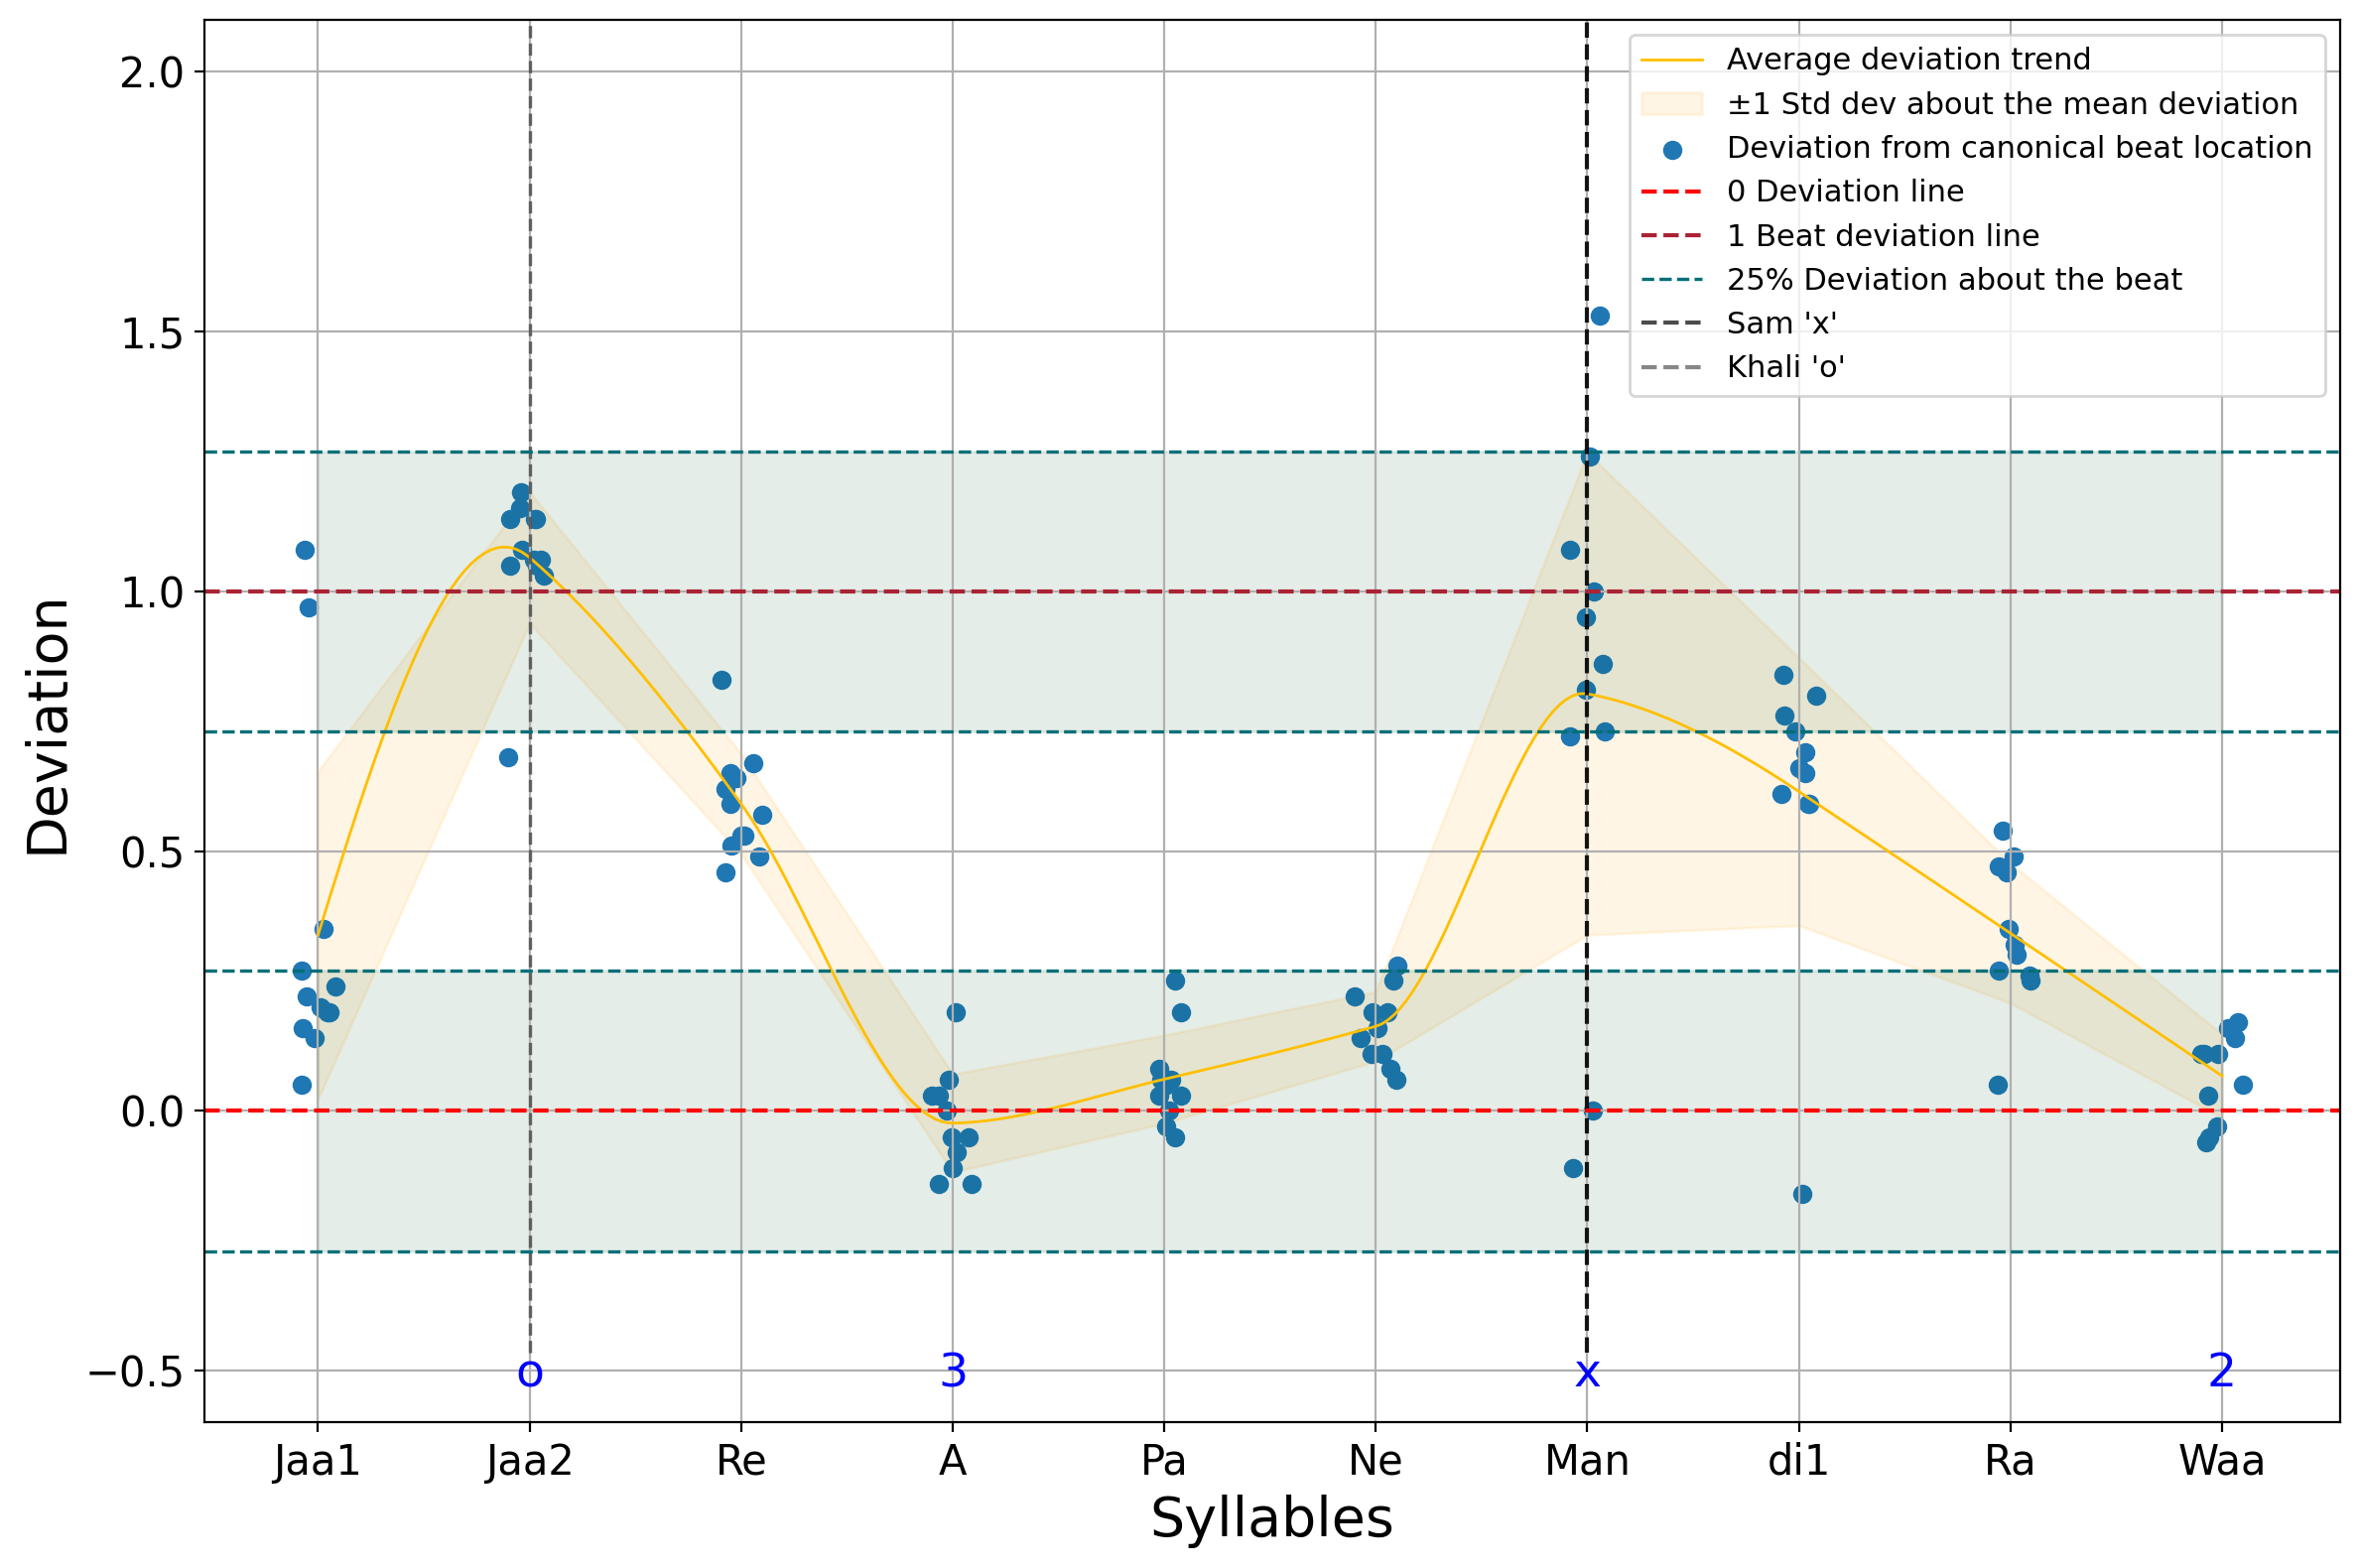

In [14]:
def plot1(folder, artist):
    files = utils2.get_file_paths(base_folder, folder, artist)

    file_name = f"{'_'.join(folder.split('_')[1:])}_{artist}"
    for i in files:
        name = i.split("/")[-1]
        if name == file_name+"_trimmed.wav": audio_file = i
        if name == file_name+"_segments.TextGrid": segments_tg = i
        if name == file_name+"_segments.txt": segments_txt = i
        if name == file_name+"_line_labels.txt": line_labels = i
        if name == file_name+"_labels.TextGrid" or i == file_name+"_syllable_corrected.TextGrid": labels_tg = i
        if name == file_name+"_raw_syllables.TextGrid": raw_labels_tg = i
        if name == file_name+"_labels.txt": labels_txt = i
        if name == file_name+"_trimmed_gaudiolab_other.wav": audio_ss_other = i
        if name == file_name+"_trimmed_gaudiolab_vocal.wav": audio_ss_vocal = i
        if name == file_name+"_tabla.TextGrid": tabla_tg = i
        if name == file_name+"crepe_f0.pkl": f0_crepe_pkl = i


    sr = 16000
    y, sr = librosa.load(audio_file, sr=sr)


    observations_per_id, manual_onsets_plot, manual_labels_plot, num_manual_onsets, sample_duration, split_onsets, split_onsets_labels, manual_tabla_onsets, manual_tabla_labels, vibhag_labels_list, mean_sam_interval, one_matra_interval, mpm, alotted_beats = expressiveness_measure_new.expressive_timing(folder, artist, prom=0.12, inter_onset_threshold=40, manual=True)
    
    #comment the following 1 statement for using complete composition
    observations_per_id = merge_by_syllable_first_key(observations_per_id, syl_list, label_list)

    syllable_count, syllables_list, avg_dev_frn, avg_dev, avg_matra_durn, frn_dev_list, taal_marks, id_list = metrics(observations_per_id)
    frn_dev_list_flat = np.array([i for item in frn_dev_list for i in item])
    x_positions = range(len(syllables_list))
    x_positions = [i for i in range(len(syllables_list))]

    Q3 = np.percentile(frn_dev_list_flat, 90)
    Q1 = np.percentile(frn_dev_list_flat, 10)
    IQR = Q3 - Q1
    lower_bound = Q1 - 0.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # print("upper bound = ", upper_bound)
    # print("lower bound = ", lower_bound)


    # frn_dev_list_no_outlier = frn_dev_list_flat[(frn_dev_list_flat >= lower_bound) & (frn_dev_list_flat <= upper_bound)]
    # print(frn_dev_list_no_outlier)
    frn_dev_list_no_outlier = []

    for dev_list in frn_dev_list:
        dev_list = np.array(dev_list)
        dev_list = dev_list[(dev_list >= lower_bound) & (dev_list <= upper_bound)]
        frn_dev_list_no_outlier.append(dev_list)

    # print(frn_dev_list_no_outlier)

    # devns_of_devns = [np.std(np.array(i)[(np.array(i)>=lower_bound) & (np.array(i)<=upper_bound)]) for i in frn_dev_list]
    devns_of_devns = [np.std(np.array(i)) for i in frn_dev_list_no_outlier]


    print(f"average deviation fraction = {np.round(np.mean(np.abs(avg_dev_frn)), 2)}, average deviation = {np.round(np.mean(np.abs(avg_dev)),2)}s, average matra duration {np.round(np.mean(np.abs(avg_matra_durn)), 2)}s")
    # print(f"standard deviation of the deviations = {np.round(np.std(frn_dev_list_no_outlier), 2)}")

    x_plot = []
    y_plot = []

    for i, (x, y_list) in enumerate(zip(x_positions, frn_dev_list)):
        for j in y_list:
            x_plot.append(x)
            y_plot.append(j)
    no_of_points = len(y_plot)

    print(f"number of syllable points = {no_of_points}")

    # Convert data to DataFrame for easier manipulation
    df = pd.DataFrame({'x': x_plot, 'y': y_plot})
    df1 = df 
    # Define outlier threshold
    # outlier_threshold = 2.0  # Adjust threshold as needed for your data
    # df['is_outlier'] = (df['y'] > upper_bound) | (df['y'] < lower_bound)

    jitter_strength = 0.1 # Adjust jitter strength as needed
    df['x_jittered'] = df['x'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df))


    # Prepare the plot
    plt.figure(figsize=(12, 8))
    
    #curve fitting the means of deviations
    x_smooth = np.linspace(x_positions[0], x_positions[-1], 300)  # Create a smoother range of x values
    akima = Akima1DInterpolator(x_positions, avg_dev_frn)
    y_smooth = akima(x_smooth)

    # Plot the interpolated line
    plt.plot(x_smooth, y_smooth, color='#FFBF00', linewidth = 1, label = "Average deviation trend")

    # # Shaded ribbon around the moving average
    plt.fill_between(x_positions, np.array(avg_dev_frn) - np.array(devns_of_devns), np.array(avg_dev_frn) + np.array(devns_of_devns), color='orange', alpha=0.1, label='±1 Std dev about the mean deviation')


    # df['is_outlier'] = (df['y'] > 1.75) | (df['y'] < -0.5)
    # df = df[~df['is_outlier']]

    # Taal marks text
    for x, label in zip(x_positions, taal_marks):
        if label=='x':
            plt.axvline(x, 0.05, 1, color='#000000', linestyle='--', linewidth=1.5, alpha=0.9)
        if label=='o':
            plt.axvline(x,0.05, 1, color='#555555', linestyle='--', linewidth=1.20, alpha=0.9)
        if label=='२':
            label = "2"
        if label=='३':
            label = "3" 
        plt.text(x, -0.6+0.05, label, ha='center', va='bottom', fontsize=17, color='blue')

    # Scatter plot for non-outliers with jittered x-values
    plt.scatter(df['x_jittered'], df['y'], alpha=1, label='Deviation from canonical beat location', color = '#1f77b4')

    #scatter plot for avg devn frn
    # plt.scatter(x_positions, avg_dev_frn, alpha = 1, label = "Average Deviation", color = '#00aaaa', s = 10)

    # outliers = df1[df1['is_outlier']]
    # if not outliers.empty:
    #     outlier_text = "\n".join([f"Syllable {syllables_list[int(x)]}: {y:.2f}" for x, y in zip(outliers['x'], outliers['y'])])
    #     plt.gcf().text(1.02, 0.5, f"Outliers:\n{outlier_text}", va='center', ha='left', fontsize=15, color='red')

    #100ms
    dev_100ms = round(0.1/one_matra_interval,2)

    y1 = np.full(len(x_positions), 0-dev_100ms)  # Horizontal line at y=-0.25
    y2 = np.full(len(x_positions), dev_100ms)  # Horizontal line at y=0.25
    y3 = np.full(len(x_positions), 1-dev_100ms)  # Horizontal line at y=0.75
    y4 = np.full(len(x_positions), 1+dev_100ms)  # Horizontal line at y=1.25

    # Axis labels and title
    plt.axhline(0, color='red', linewidth=1.5, linestyle='--', label='0 Deviation line')
    plt.axhline(1, color='#aa2334', linewidth=1.5, linestyle='--', label='1 Beat deviation line')
    plt.axhline(0-dev_100ms, color="#006F77", linewidth=1.2, linestyle='--')
    plt.axhline(dev_100ms, color='#006F77', linewidth=1.2, linestyle='--')
    plt.axhline(1-dev_100ms, color='#006F77', linewidth=1.2, linestyle='--')
    plt.axhline(1+dev_100ms, color='#006F77', linewidth=1.2, linestyle='--')
    plt.axhline(-10, color = '#006F77', linewidth=1.2, linestyle='--', label = "25% Deviation about the beat")

    plt.axhline(-10, color='#000000', linestyle='--', linewidth=1.5, alpha=0.7, label = "Sam 'x'")
    plt.axhline(-10, color='#555555', linestyle='--', linewidth=1.5, alpha=0.7, label = "Khali 'o'")

    # Use indices as x values
    x = np.arange(len(y1))
    plt.fill_between(x, y1, y2, color='#005522', alpha=0.1)
    plt.fill_between(x, y3, y4, color='#005522', alpha=0.1)

    plt.xticks(ticks=x_positions, labels = [ja_jare_eng_dict[i] for i in syllables_list], fontsize=15) #labels = [yeri_aali_eng_dict[i] for i in syllables_list] for 
    plt.yticks(fontsize=15)
    plt.xlabel("Syllables", fontsize=20)
    plt.ylabel("Deviation", fontsize = 20)
    filename1 = file_name.replace("gaudiolab_", "")
    # plt.title(f'Deviation from canonical note as a matra fraction | {filename1}', fontsize=25)

    # Final plot adjustments
    plt.ylim(-0.6, 2.1)
    plt.tight_layout()
    plt.grid()
    plt.legend(fontsize=11)
    plt.show()
    # uncomment the follwing line for audio playback
    # ipd.display(ipd.Audio(audio_file, rate=sr)) 

plot1(folder, artist)

In [15]:
def metrics2(observations_per_id):

    label_map_no_NA = [line for lines in observations_per_id.values() for line in lines]

    observns_per_beat = {}
    for i in range(1, 17):
        for line in label_map_no_NA:
            if int(line[1][3][5:]) == i:
                if i in observns_per_beat:
                    observns_per_beat[i].append(line)
                else:
                    observns_per_beat[i] = [line]

    avg_dev =[]
    frn_dev_list = []
    avg_dev_frn = []
    taal_marks = []
    avg_matra_durn = []
    
    for beat in observns_per_beat:
        lines = observns_per_beat[beat]
        taal_marks.append(lines[0][1][1])
        sam_dev = 0
        sam_dev_frn = 0
        sam_matra = 0
        frn_devs = []
        for i in range(len(lines)):
            sam_dev_frn+=lines[i][0][3]
            sam_dev+=lines[i][0][2]
            sam_matra+=lines[i][1][4]
            frn_devs.append(lines[i][0][3])
        frn_dev_list.append(frn_devs)
        avg_dev_frn.append(sam_dev_frn/len(lines))
        avg_dev.append(sam_dev/len(lines))
        avg_matra_durn.append(sam_matra/len(lines))
    return observns_per_beat, avg_dev_frn, avg_dev, avg_matra_durn, frn_dev_list, taal_marks
    

### One cycle plot

ja_jare_ABD
duration of one taal cycle:  5.88 s
duration of one matra:  0.37 s
mpm:  163.29
standard deviation of the duration of taal cycles  0.17 s
number of syllable points = 213


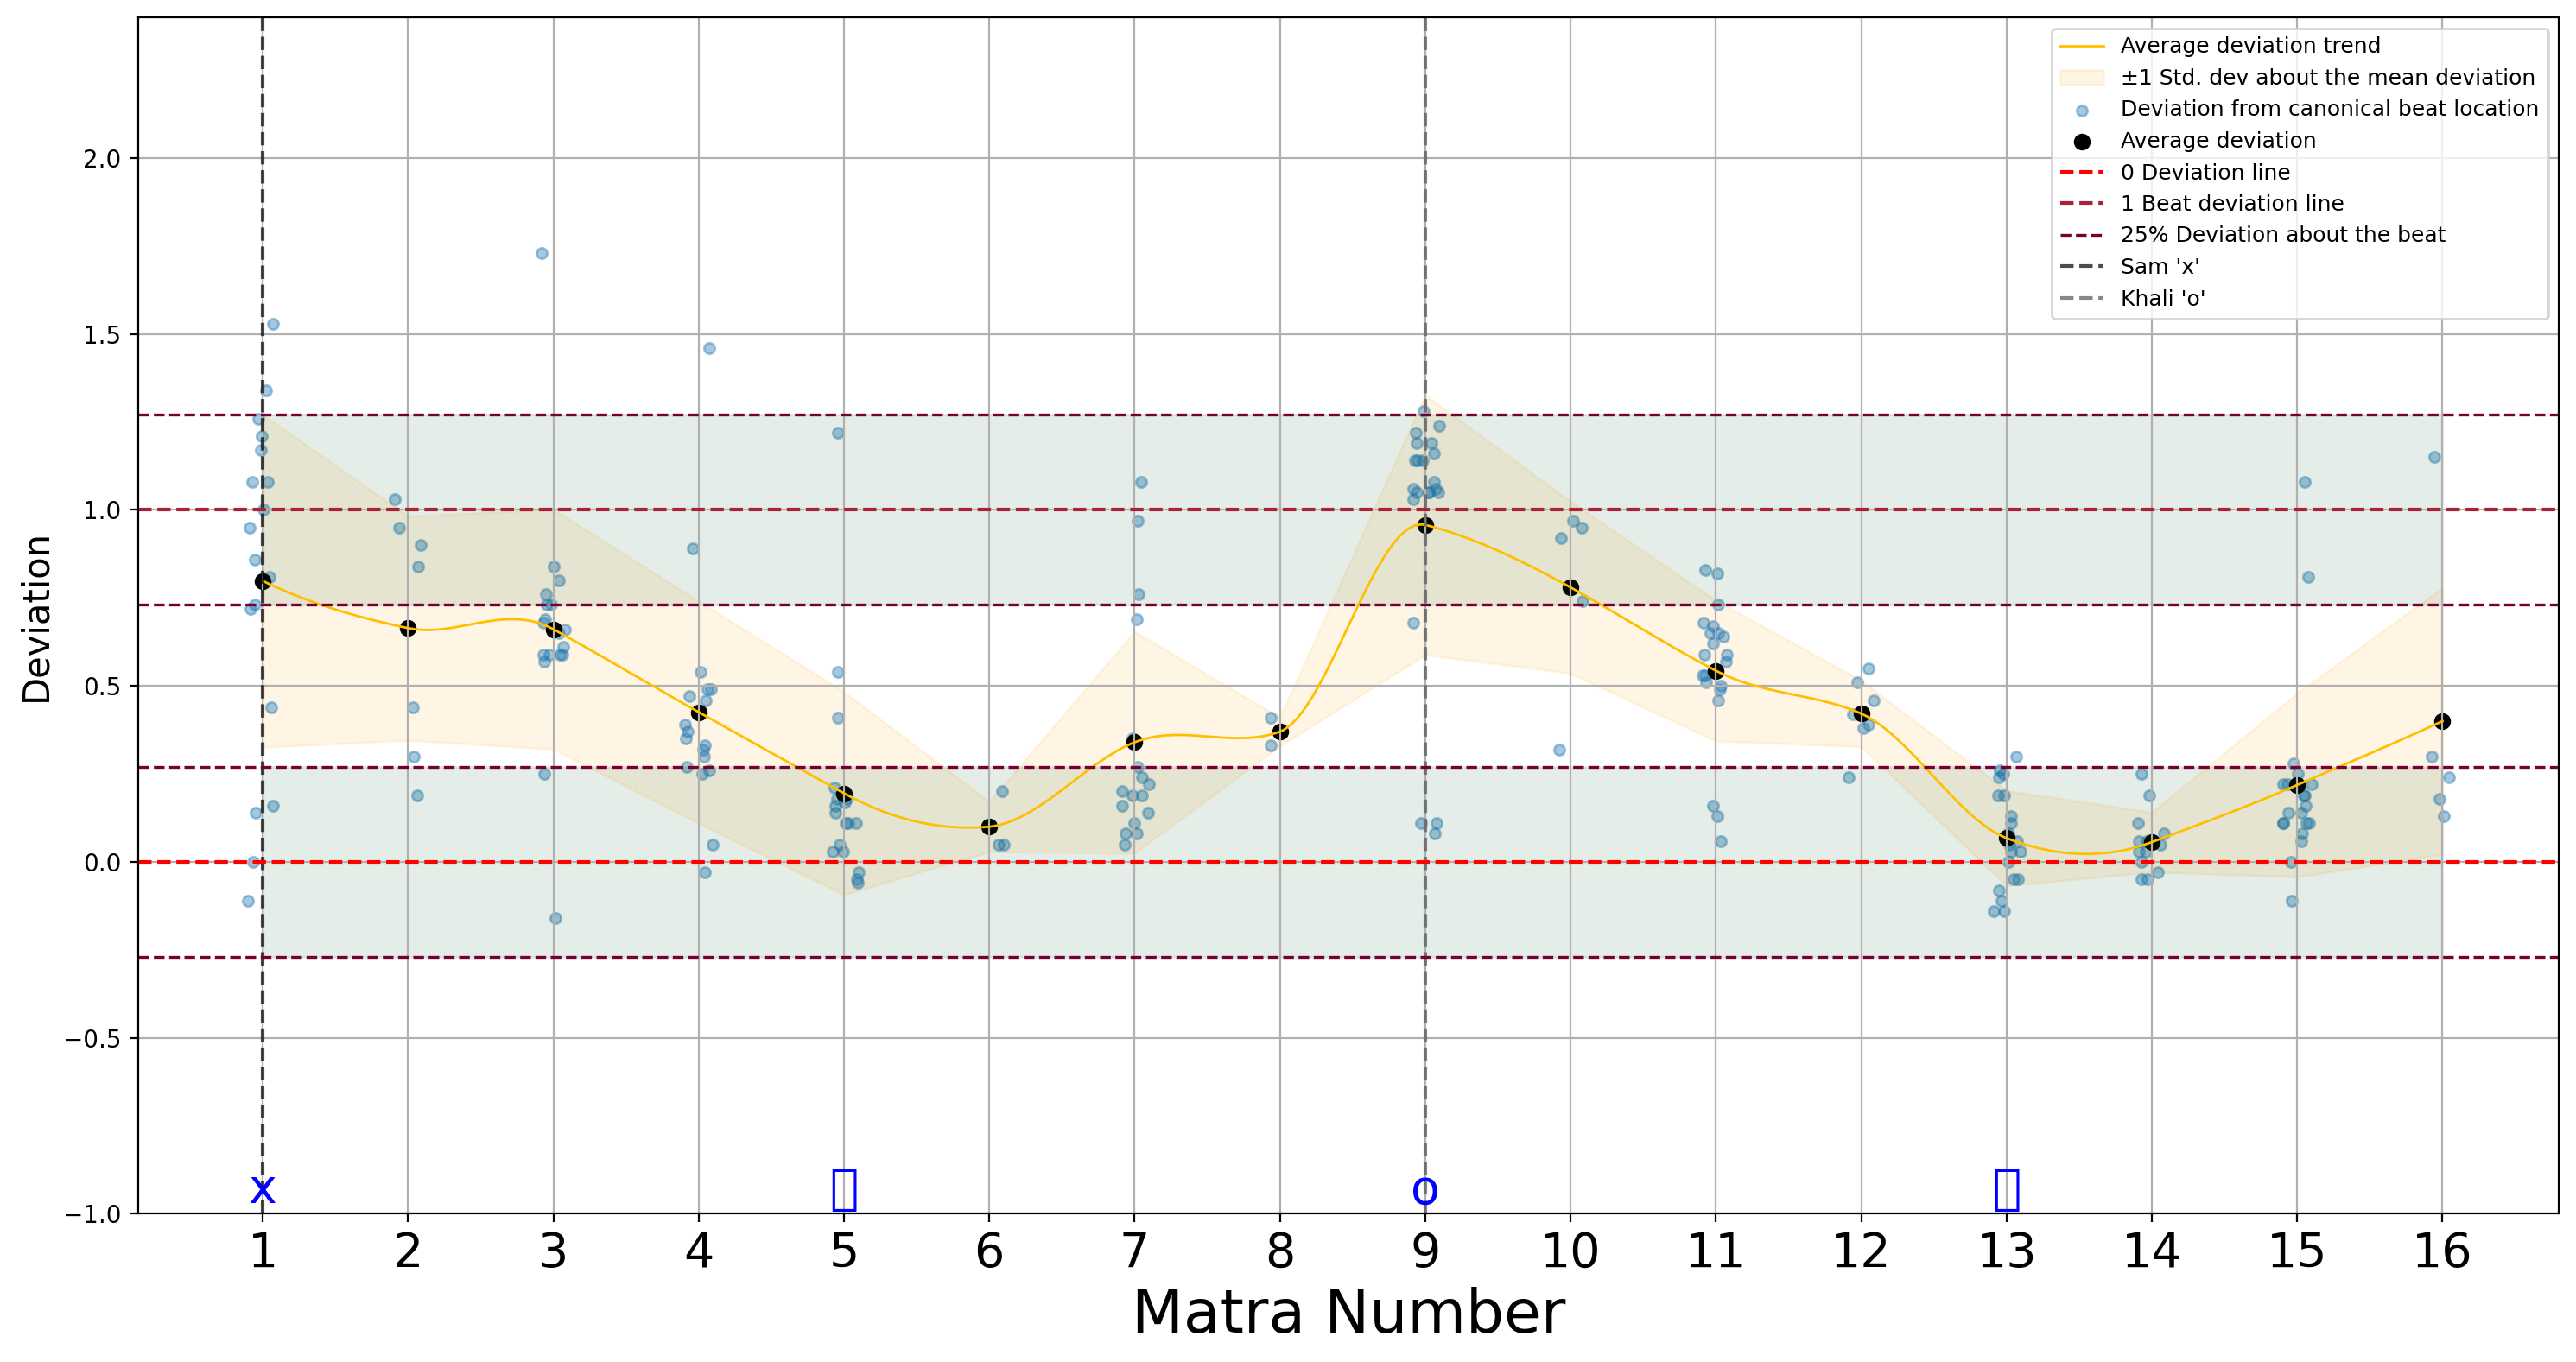

In [16]:
def one_cycle_plot(folder, artist):
    files = utils2.get_file_paths(base_folder, folder, artist)

    file_name = f"{'_'.join(folder.split('_')[1:])}_{artist}"
    for i in files:
        name = i.split("/")[-1]
        if name == file_name+"_trimmed.wav": audio_file = i
        if name == file_name+"_segments.TextGrid": segments_tg = i
        if name == file_name+"_segments.txt": segments_txt = i
        if name == file_name+"_line_labels.txt": line_labels = i
        if name == file_name+"_labels.TextGrid" or i == file_name+"_syllable_corrected.TextGrid": labels_tg = i
        if name == file_name+"_raw_syllables.TextGrid": raw_labels_tg = i
        if name == file_name+"_labels.txt": labels_txt = i
        if name == file_name+"_trimmed_gaudiolab_other.wav": audio_ss_other = i
        if name == file_name+"_trimmed_gaudiolab_vocal.wav": audio_ss_vocal = i
        if name == file_name+"_tabla.TextGrid": tabla_tg = i
        if name == file_name+"crepe_f0.pkl": f0_crepe_pkl = i

    sr = 16000  
    y, sr = librosa.load(audio_file, sr=sr)


    observations_per_id, manual_onsets_plot, manual_labels_plot, num_manual_onsets, sample_duration, split_onsets, split_onsets_labels, manual_tabla_onsets, manual_tabla_labels, vibhag_labels_list, mean_sam_interval, one_matra_interval, mpm, alotted_beats = expressiveness_measure_new.expressive_timing(folder, artist, prom=0.12, inter_onset_threshold=40, manual=True)
    observns_per_beat, avg_dev_frn, avg_dev, avg_matra_durn, frn_dev_list, taal_marks = metrics2(observations_per_id)

    x_positions = [i for i in range(16)]
    beat_numbers = [i for i in range(1, 17)]

    devns_of_devns = [np.std(i) for i in frn_dev_list]

    x_plot = []
    y_plot = []

    for i, (x, y_list) in enumerate(zip(x_positions, frn_dev_list)):
        for j in y_list:
            x_plot.append(x)
            y_plot.append(j)
    no_of_points = len(y_plot)

    print(f"number of syllable points = {no_of_points}")

    # Convert data to DataFrame for easier manipulation
    df = pd.DataFrame({'x': x_plot, 'y': y_plot})

    jitter_strength = 0.1 # Adjust jitter strength as needed
    df['x_jittered'] = df['x'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df))

    #preparing the plot
    plt.figure(figsize=(15, 8))
    
    #curve fitting the means of deviations
    x_smooth = np.linspace(x_positions[0], x_positions[-1], 300)  # Create a smoother range of x values
    akima = Akima1DInterpolator(x_positions, avg_dev_frn)
    y_smooth = akima(x_smooth)

    # Plot the interpolated line
    plt.plot(x_smooth, y_smooth, color='#FFBF00', linewidth = 1, label = "Average deviation trend")

    # # Shaded ribbon around the moving average
    plt.fill_between(x_positions, np.array(avg_dev_frn) - np.array(devns_of_devns), np.array(avg_dev_frn) + np.array(devns_of_devns), color='orange', alpha=0.1, label='±1 Std. dev about the mean deviation')

    # Scatter plot for all points with jittered x-values
    plt.scatter(df['x_jittered'], df['y'], alpha=0.4, label='Deviation from canonical beat location', s = 20, color = '#1f77b4')

    #scatter plot for avg devn frn
    plt.scatter(x_positions, avg_dev_frn, alpha = 1, label = "Average deviation", color = '#000000')
    
    # Taal marks text
    for x, label in zip(x_positions, taal_marks):
        if label=='x':
            plt.axvline(x, color='#000000', linestyle='--', linewidth=1.5, alpha=0.7)
        if label=='o':
            plt.axvline(x, color='#555555', linestyle='--', linewidth=1.5, alpha=0.7)
        plt.text(x, -1.0, label, ha='center', va='bottom', fontsize=20, color='blue')


    #100ms
    dev_100ms = round(0.1/one_matra_interval,2)

    y1 = np.full(len(x_positions), 0-dev_100ms)  # Horizontal line at y=-0.25
    y2 = np.full(len(x_positions), dev_100ms)  # Horizontal line at y=0.25
    y3 = np.full(len(x_positions), 1-dev_100ms)  # Horizontal line at y=0.75
    y4 = np.full(len(x_positions), 1+dev_100ms)  # Horizontal line at y=1.25


    # Axis labels and title
    plt.axhline(0, color='#ff0000', linewidth=1.5, linestyle='--', label='0 Deviation line')
    plt.axhline(1, color='#aa2334', linewidth=1.5, linestyle='--', label='1 Beat deviation line')
    plt.axhline(0-dev_100ms, color='#770033', linewidth=1.2, linestyle='--')
    plt.axhline(dev_100ms, color='#770033', linewidth=1.2, linestyle='--')
    plt.axhline(1-dev_100ms, color='#770033', linewidth=1.2, linestyle='--')
    plt.axhline(1+dev_100ms, color='#770033', linewidth=1.2, linestyle='--')
    plt.axhline(-10, color = '#770033', linewidth=1.2, linestyle='--', label = "25% Deviation about the beat")

    plt.axhline(-10, color='#000000', linestyle='--', linewidth=1.5, alpha=0.7, label = "Sam 'x'")
    plt.axhline(-10, color='#555555', linestyle='--', linewidth=1.5, alpha=0.7, label = "Khali 'o'")

    # Use indices as x values
    x = np.arange(len(y1))
    plt.fill_between(x, y1, y2, color='#005522', alpha=0.1)
    plt.fill_between(x, y3, y4, color='#005522', alpha=0.1)

    plt.xticks(ticks=x_positions, labels=beat_numbers, ha='center', fontsize=20)
    plt.xlabel("Matra Number", fontsize=25)
    plt.ylabel("Deviation", fontsize = 15)
    filename1 = file_name.replace("gaudiolab_", "")
    # plt.title(f'Deviation from Canonical Note as a Matra Fraction | {filename1}', fontsize=25)

    # Final plot adjustments
    plt.ylim(-1, 2.4)
    plt.tight_layout()
    plt.grid()
    plt.legend(prop={'size': 9}, loc = 'upper right')
    plt.show()
    # uncomment the follwing line for audio playback
    # ipd.display(ipd.Audio(audio_file, rate=sr))


# for i in audio_file_number_list:
one_cycle_plot(folder, artist)


Distance between Adjacent syllables

In [17]:
def metrics3(observations_per_id, alotted_beats):
    # label_map_no_NA
    for i in observations_per_id:          # for making the internal id of each syllable same as its key id
        lines = observations_per_id[i]
        for line in lines:
            line[1][3] = i

    label_map_no_NA = [line for lines in observations_per_id.values() for line in lines]
    # sorted_label_map
    sorted_label_map = sorted(label_map_no_NA, key=lambda x: x[0][0])
    # print(sorted_label_map)

    for i in range(len(sorted_label_map)):
        line = sorted_label_map[i]
        if i!=len(sorted_label_map)-1:
            this_time = sorted_label_map[i][0][0]
            next_time = sorted_label_map[i+1][0][0]
            if next_time - this_time<4.5:
                sorted_label_map[i][0].insert(1, round(((next_time-this_time)/line[1][4]),2))
            else:
                sorted_label_map[i][0].insert(1, alotted_beats[sorted_label_map[i][1][3]])
        else:
            sorted_label_map[i][0].insert(1, round(((duration-this_time)/line[1][4]), 2))


    observations_per_id1 = {}
    

    for id in list(observations_per_id.keys()):
        for line in sorted_label_map:
            if line[1][3] == id:
                # print(line[1][3]) if id == "C1L1B7" else None
                if id in observations_per_id1:
                    observations_per_id1[id].append(line)
                else:
                    observations_per_id1[id] = [line]
    adj_dist_list = []
    
    for i in observations_per_id1:
        lines = observations_per_id1[i]
        adj_dist = [lines[j][0][1] for j in range(len(lines))]
        adj_dist_list.append(adj_dist)
    avg_adj_dist = [np.mean(i) for i in adj_dist_list]
    return adj_dist_list, avg_adj_dist

ja_jare_ABD
duration of one taal cycle:  5.88 s
duration of one matra:  0.37 s
mpm:  163.29
standard deviation of the duration of taal cycles  0.17 s
standard deviation of the adjacent distances = 0.73
number of syllable points = 112


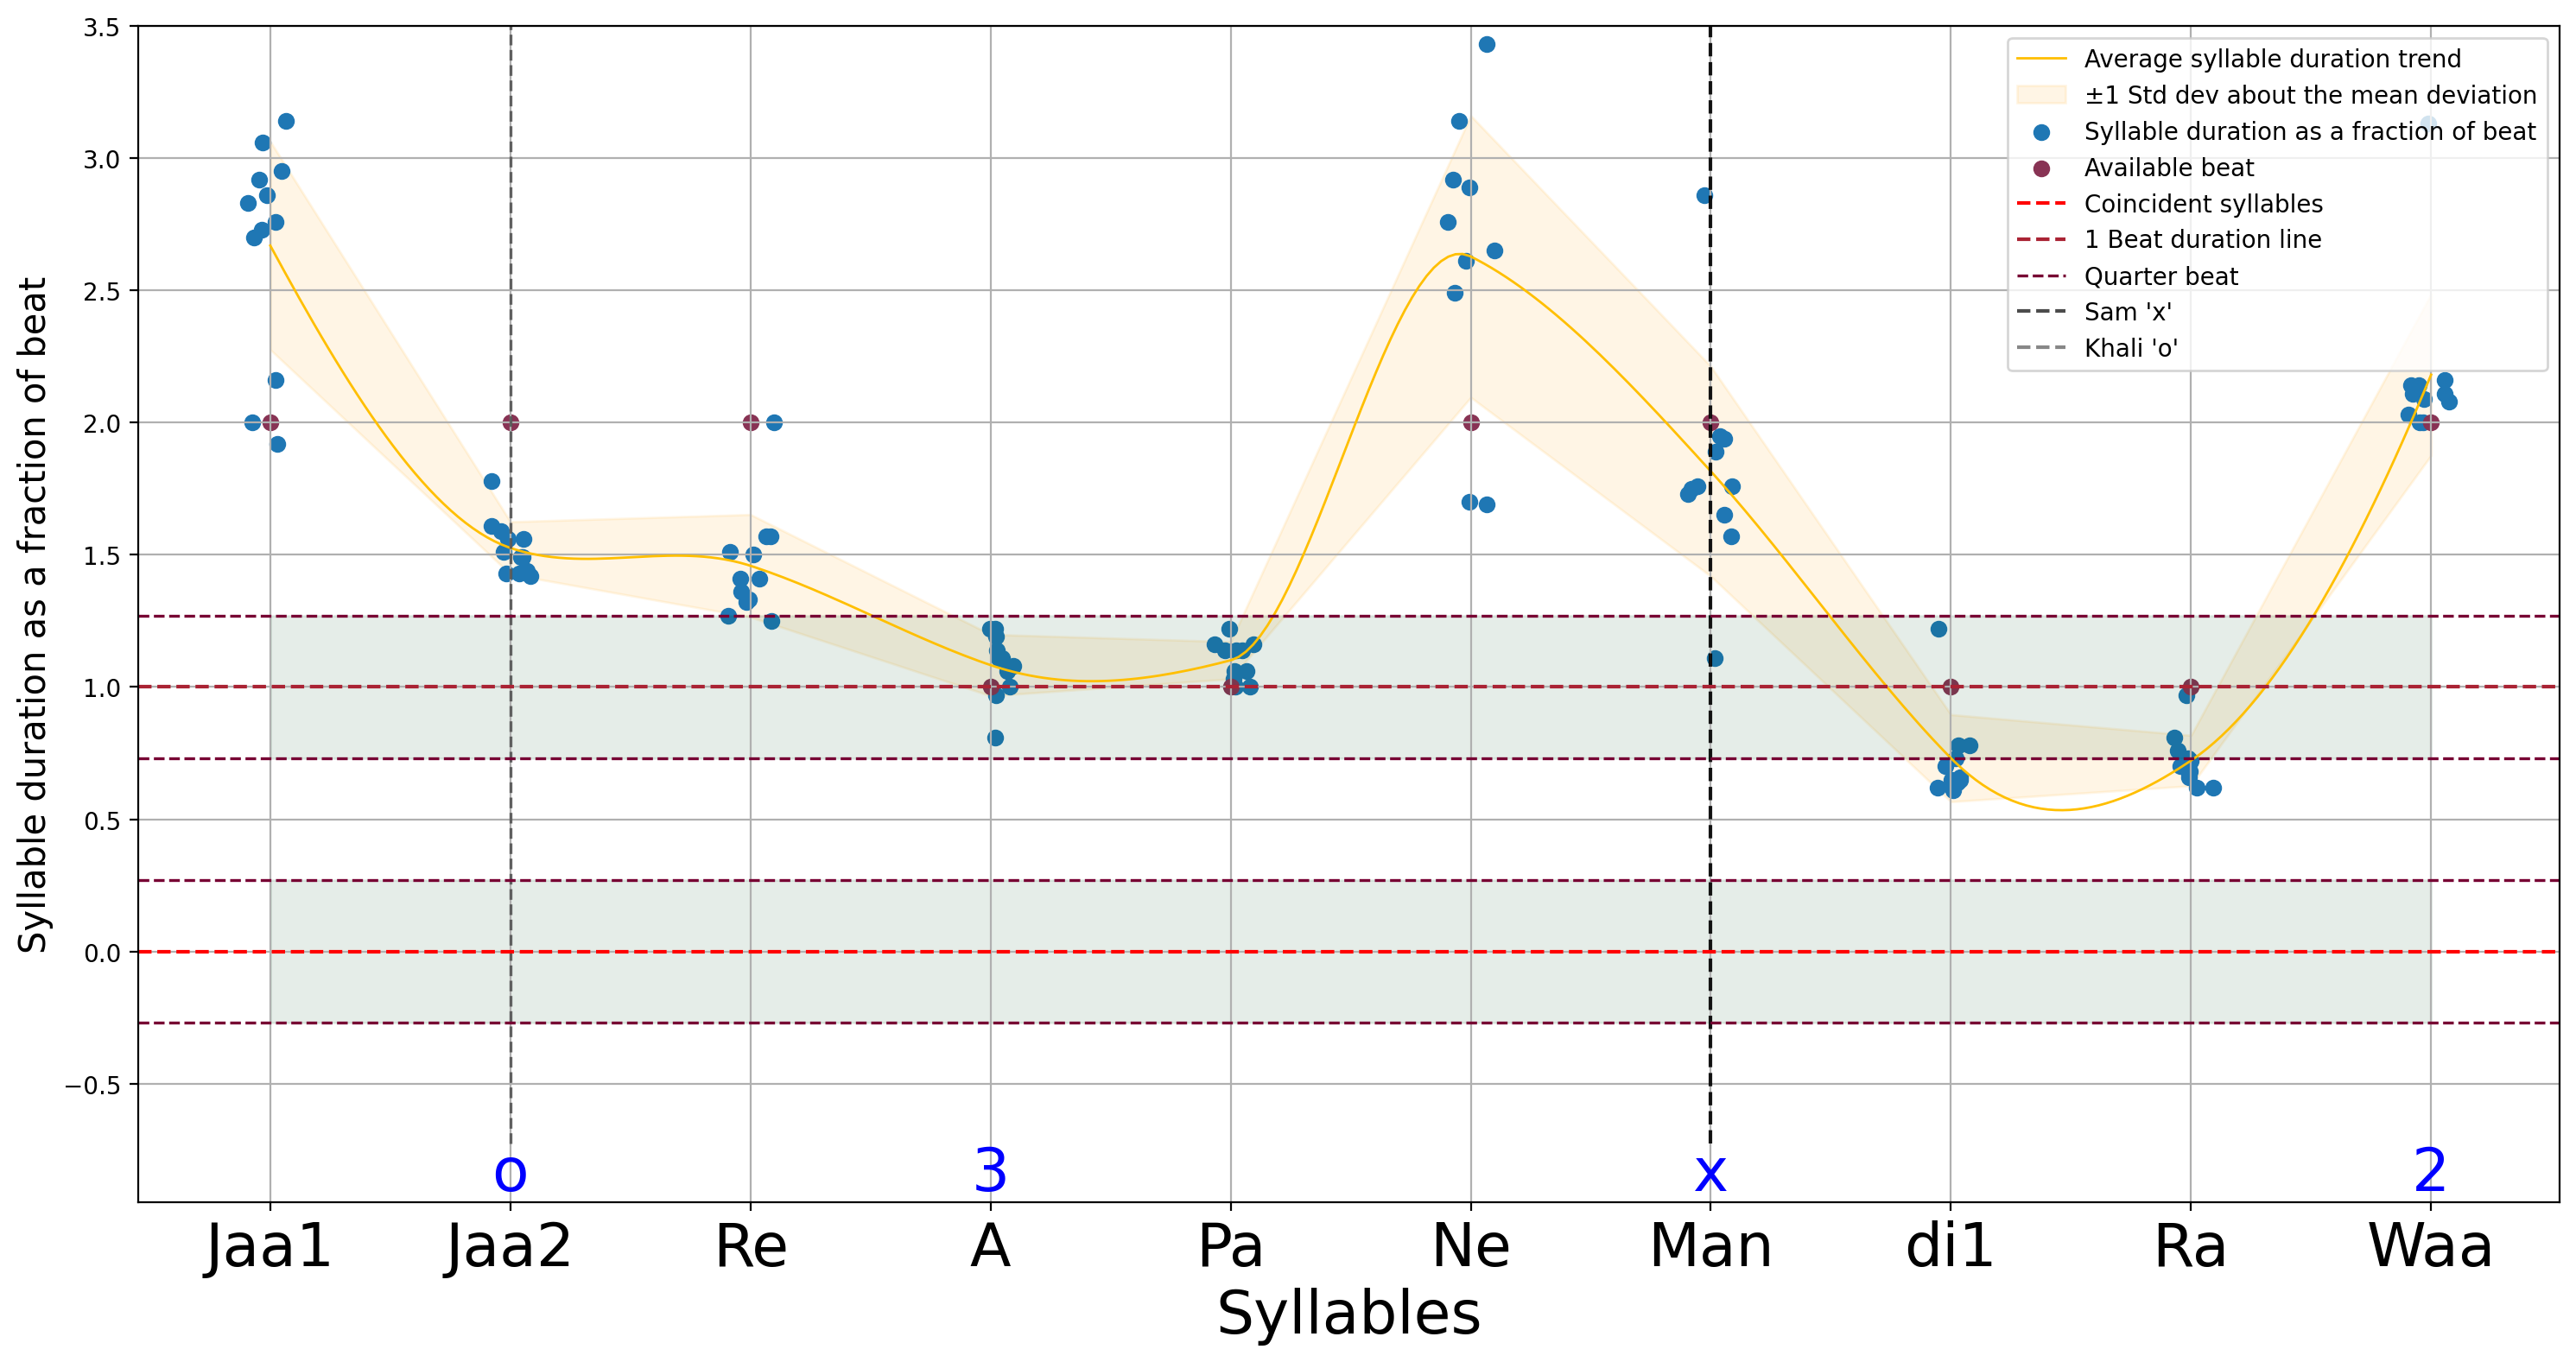

In [19]:
def plot_adj_distance(folder, artist):
    files = utils2.get_file_paths(base_folder, folder, artist)

    file_name = f"{'_'.join(folder.split('_')[1:])}_{artist}"
    for i in files:
        name = i.split("/")[-1]
        if name == file_name+"_trimmed.wav": audio_file = i
        if name == file_name+"_segments.TextGrid": segments_tg = i
        if name == file_name+"_segments.txt": segments_txt = i
        if name == file_name+"_line_labels.txt": line_labels = i
        if name == file_name+"_labels.TextGrid" or i == file_name+"_syllable_corrected.TextGrid": labels_tg = i
        if name == file_name+"_raw_syllables.TextGrid": raw_labels_tg = i
        if name == file_name+"_labels.txt": labels_txt = i
        if name == file_name+"_trimmed_gaudiolab_other.wav": audio_ss_other = i
        if name == file_name+"_trimmed_gaudiolab_vocal.wav": audio_ss_vocal = i
        if name == file_name+"_tabla.TextGrid": tabla_tg = i
        if name == file_name+"crepe_f0.pkl": f0_crepe_pkl = i

    sr = 16000
    y, sr = librosa.load(audio_file, sr=sr)


    observations_per_id, manual_onsets_plot, manual_labels_plot, num_manual_onsets, sample_duration, split_onsets, split_onsets_labels, manual_tabla_onsets, manual_tabla_labels, vibhag_labels_list, mean_sam_interval, one_matra_interval, mpm, alotted_beats = expressiveness_measure_new.expressive_timing(folder, artist, prom=0.12, inter_onset_threshold=40, manual=True)
    #comment the following 1 statement for using complete composition
    observations_per_id = merge_by_syllable_first_key(observations_per_id, syl_list, label_list)
    syllable_count, syllables_list, avg_dev_frn, avg_dev, avg_matra_durn, frn_dev_list, taal_marks, id_list = metrics(observations_per_id)

    adj_dist_list, avg_adj_dist = metrics3(observations_per_id, alotted_beats)

    adj_dist_list_flat = np.array([i for item in adj_dist_list for i in item])


    x_positions = range(len(syllables_list))
    x_positions = [i for i in range(len(syllables_list))]
    
    Q3 = np.percentile(adj_dist_list_flat, 90)
    Q1 = np.percentile(adj_dist_list_flat, 10)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    adj_dist_list_no_outlier = adj_dist_list_flat[(adj_dist_list_flat >= lower_bound) & (adj_dist_list_flat <= upper_bound)]
    
    devns_of_devns = [np.std(np.array(i)[(np.array(i)>=lower_bound) & (np.array(i)<=upper_bound)]) for i in adj_dist_list]

    # print(f"average deviation fraction = {np.round(np.mean(np.abs(avg_dev_frn)), 2)}, average deviation = {np.round(np.mean(np.abs(avg_dev)),2)}s, average matra duration {np.round(np.mean(np.abs(avg_matra_durn)), 2)}s")
    print(f"standard deviation of the adjacent distances = {np.round(np.std(adj_dist_list_no_outlier), 2)}")

    x_plot = []
    y_plot = []

    outlier_threshold = 3.5

    adj_dist_list = [[i for i in sublist if i<=outlier_threshold] for sublist in adj_dist_list]
    avg_adj_dist = [np.mean(i) if len(i)!=0 else 1 for i in adj_dist_list ]

    for i, (x, y_list) in enumerate(zip(x_positions, adj_dist_list)):
        for j in y_list:
            x_plot.append(x)
            y_plot.append(j)
    no_of_points = len(y_plot)

    print(f"number of syllable points = {no_of_points}")

    # Convert data to DataFrame for easier manipulation
    df = pd.DataFrame({'x': x_plot, 'y': y_plot})
    df1 = df 

    jitter_strength = 0.1 # Adjust jitter strength as needed
    df['x_jittered'] = df['x'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(df))


    # Prepare the plot
    plt.figure(figsize=(15, 8))
    
    #curve fitting the means of deviations
    x_smooth = np.linspace(x_positions[0], x_positions[-1], 300)  # Create a smoother range of x values
    akima = Akima1DInterpolator(x_positions, avg_adj_dist)
    y_smooth = akima(x_smooth)

    # Plot the interpolated line
    plt.plot(x_smooth, y_smooth, color='#FFBF00', linewidth = 1, label = "Average syllable duration trend")

    # # Shaded ribbon around the moving average
    plt.fill_between(x_positions, np.array(avg_adj_dist) - np.array(devns_of_devns), np.array(avg_adj_dist) + np.array(devns_of_devns), color='orange', alpha=0.1, label='±1 Std dev about the mean deviation')

    x_min = -0.95

    # Taal marks text
    for x, label in zip(x_positions, taal_marks):
        if label=='x':
            plt.axvline(x, 0.05, 1, color='#000000', linestyle='--', linewidth=1.5, alpha=0.9)
        if label=='o':
            plt.axvline(x, 0.05, 1, color='#555555', linestyle='--', linewidth=1.20, alpha=0.9)
        if label=='२':
            label = "2"
        if label=='३':
            label = "3" 
        plt.text(x, x_min, label, ha='center', va='bottom', fontsize=25, color='blue')

    # Scatter plot for non-outliers with jittered x-values
    plt.scatter(df['x_jittered'], df['y'], alpha=1, label='Syllable duration as a fraction of beat', color = '#1f77b4')
    plt.scatter(x_positions, [alotted_beats[i] for i in id_list], alpha=1, label='Available beat', color = '#883354')


    dev_100ms = round(0.1/one_matra_interval,2)

    y1 = np.full(len(x_positions), 0-dev_100ms)  # Horizontal line at y=-0.25
    y2 = np.full(len(x_positions), dev_100ms)  # Horizontal line at y=0.25
    y3 = np.full(len(x_positions), 1-dev_100ms)  # Horizontal line at y=0.75
    y4 = np.full(len(x_positions), 1+dev_100ms)  # Horizontal line at y=1.25

    # Axis labels and title
    plt.axhline(0, color='red', linewidth=1.5, linestyle='--', label='Coincident syllables')
    plt.axhline(1, color='#aa2334', linewidth=1.5, linestyle='--', label='1 Beat duration line')
    plt.axhline(0-dev_100ms, color='#770033', linewidth=1.2, linestyle='--')
    plt.axhline(dev_100ms, color='#770033', linewidth=1.2, linestyle='--')
    plt.axhline(1-dev_100ms, color='#770033', linewidth=1.2, linestyle='--')
    plt.axhline(1+dev_100ms, color='#770033', linewidth=1.2, linestyle='--')
    plt.axhline(-10, color = '#770033', linewidth=1.2, linestyle='--', label = "Quarter beat")

    plt.axhline(-10, color='#000000', linestyle='--', linewidth=1.5, alpha=0.7, label = "Sam 'x'")
    plt.axhline(-10, color='#555555', linestyle='--', linewidth=1.5, alpha=0.7, label = "Khali 'o'")

    # Use indices as x values
    x = np.arange(len(y1))
    plt.fill_between(x, y1, y2, color='#005522', alpha=0.1)
    plt.fill_between(x, y3, y4, color='#005522', alpha=0.1)

    plt.xticks(ticks=x_positions, labels=[ja_jare_eng_dict[i] for i in syllables_list], ha='center', fontsize=25) #labels = [ja_jare_eng_dict[i] for i in syllables_list]
    plt.xlabel("Syllables", fontsize=25)
    plt.ylabel("Syllable duration as a fraction of beat", fontsize = 15)
    filename1 = file_name.replace("gaudiolab_", "")
    # plt.title(f'Duration of a syllable as a fraction of beat | {filename1}', fontsize=25)

    # Final plot adjustments
    plt.ylim(x_min, outlier_threshold)
    plt.tight_layout()
    plt.grid()
    plt.legend()
    plt.show()
    # uncomment the follwing line for audio playback
    # ipd.display(ipd.Audio(audio_file, rate=sr))

plot_adj_distance(folder, artist)

In [21]:
ja_jare_eng_dict[''] = ''

### combined plot

ja_jare_ABD
duration of one taal cycle:  5.88 s
duration of one matra:  0.37 s
mpm:  163.29
standard deviation of the duration of taal cycles  0.17 s


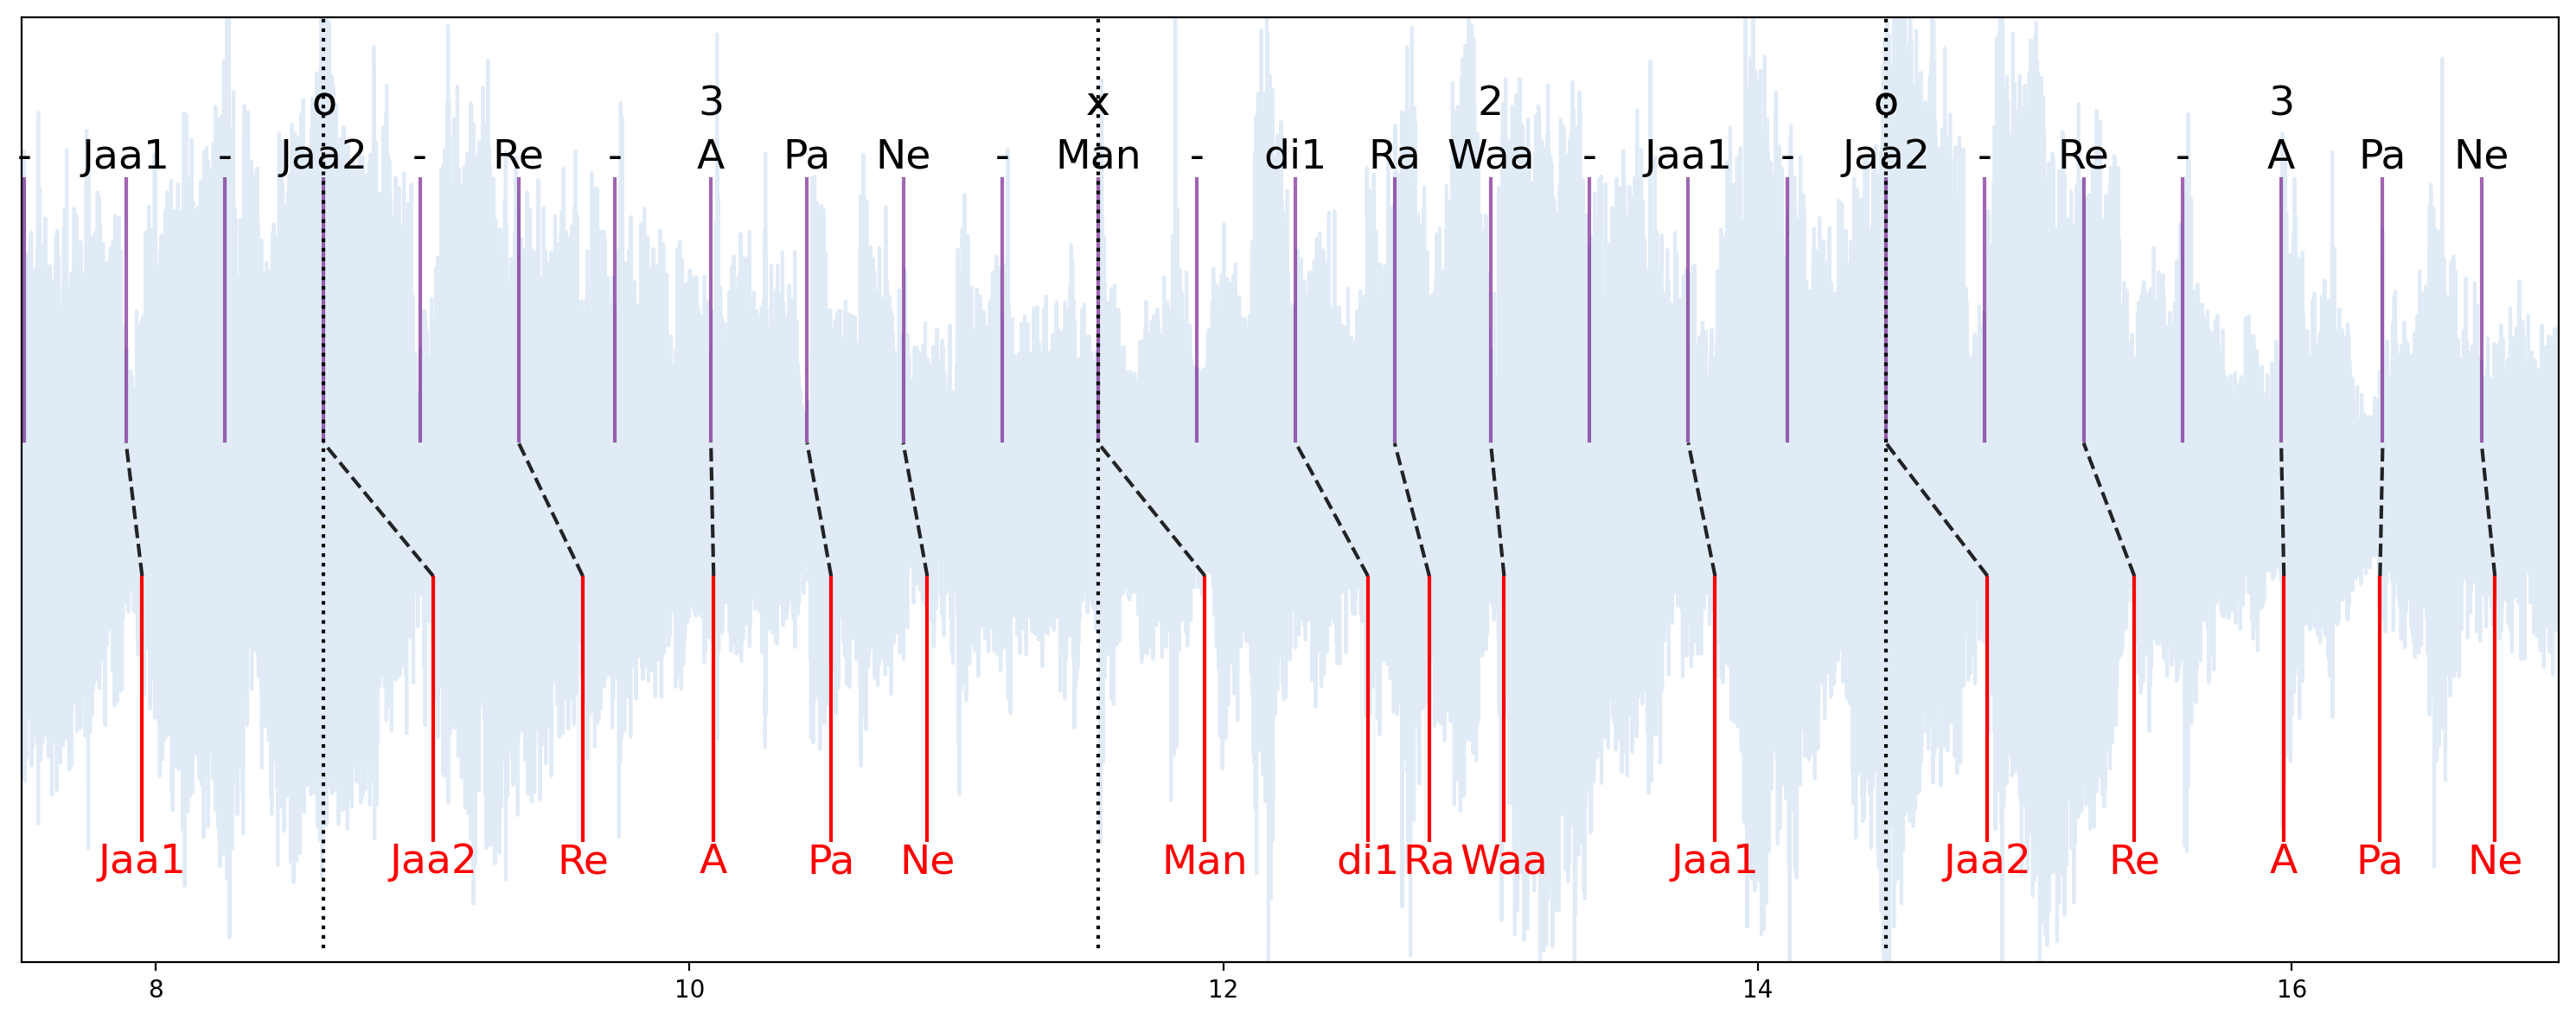

In [22]:
def combined_plot(folder, artist, prom = 0.15, start_time = 0, end_time = 20):
    files = utils2.get_file_paths(base_folder, folder, artist)

    file_name = f"{'_'.join(folder.split('_')[1:])}_{artist}"
    for i in files:
        name = i.split("/")[-1]
        if name == file_name+"_trimmed.wav": audio_file = i
        if name == file_name+"_segments.TextGrid": segments_tg = i
        if name == file_name+"_segments.txt": segments_txt = i
        if name == file_name+"_line_labels.txt": line_labels = i
        if name == file_name+"_labels.TextGrid" or i == file_name+"_syllable_corrected.TextGrid": labels_tg = i
        if name == file_name+"_raw_syllables.TextGrid": raw_labels_tg = i
        if name == file_name+"_labels.txt": labels_txt = i
        if name == file_name+"_trimmed_gaudiolab_other.wav": audio_ss_other = i
        if name == file_name+"_trimmed_gaudiolab_vocal.wav": audio_ss_vocal = i
        if name == file_name+"_tabla.TextGrid": tabla_tg = i
        if name == file_name+"crepe_f0.pkl": f0_crepe_pkl = i

    y, sr = utils2.load_audio(audio_file)
    #normalise the audio
    y = y / np.max(np.abs(y))

    y_centered = np.array(y)*0.5 + 0.35
    # Create a time axis based on the audio data
    time = np.arange(len(y))/sr
    
    observations_per_id, manual_onsets_plot, manual_labels_plot, num_manual_onsets, sample_duration, split_onsets, split_onsets_labels, manual_tabla_onsets, manual_tabla_labels, vibhag_labels_list, mean_sam_interval, one_matra_interval, mpm, alotted_beats = expressiveness_measure_new.expressive_timing(folder, artist, prom=0.12, inter_onset_threshold=40, manual=True)

    label_map_no_NA = [line for lines in observations_per_id.values() for line in lines]

    # TP, FP, FN, precision, recall, f_score, num_manual, num_pred, matched = utils2.evaluate2(detected_onsets_plot, (np.array(manual_onsets_plot)*100).astype(int))
    # print(f"precision: {precision}, recall: {recall}, f_score: {f_score}, number of manual onsets: {num_manual}, number of predicted onsets: {num_pred}")

    plt.figure(figsize = (15, 6))

    plt.plot(time, y_centered, color='#A7C7E7', alpha=0.35, label = "Waveform")

    # plt.plot(times, np.array(nov)*0.25, label='Sub-band Energy Onset Detection Function')
    # plt.xlabel("Time (s)", fontsize = 15)


    det_onset_ymax = 0.0
    man_onset_ymax = 0.28
    man_onset_ymin = 0.08
    beat_onset_ymax = 0.58
    beat_onset_ymin = 0.38
    sam_onset_ymax = 0.8
    sam_onset_ymin = 0
    man_text = man_onset_ymin                        
    can_text = beat_onset_ymax 
    sam_text = 0.62


    #detected onsets
    # plt.vlines(np.array(detected_onsets_plot)/100, det_onset_ymin, det_onset_ymax, color='#00aaaa', label='Detected Onsets')
    #manual onsets
    plt.vlines(manual_onsets_plot, man_onset_ymin, man_onset_ymax, color='#ff0000', label='Manually Marked Onsets')
    #all beat onsets 
    plt.vlines(split_onsets, beat_onset_ymin, beat_onset_ymax, color = '#61007d', label = "Canonical Syllable Positions", linestyles = 'solid', alpha = 0.6)
    #salient beat onsets
    plt.vlines(manual_tabla_onsets, sam_onset_ymin, sam_onset_ymax, color = '#000000', label = "Salient Beats", linestyles = 'dotted')


    #manual onsets labels
    for x, label in zip(manual_onsets_plot, [ja_jare_eng_dict[i] for i in manual_labels_plot]): #[ja_jare_eng_dict[i] for i in manual_labels_plot]
        if x<start_time:
            continue
        if x>end_time:
            break
        plt.text(x, man_text-0.03, s=label, ha='center', va='bottom', fontsize=17, color='red')

    # #detected onsets labels
    # for x, label in zip(np.array(detected_onsets_manual_list)/100, detected_onsets_manual_labels):
    #     if x<start_time:
    #         continue
    #     if x>end_time:
    #         break
    #     plt.text(x, det_text, s=label, ha='center', va='bottom', fontsize=19, color='#005555', fontweight = 'bold')
    
    #tali khali labels
    for x, label in zip(manual_tabla_onsets, manual_tabla_labels):
        if x<start_time:
            continue
        if x>end_time:
            break
        plt.text(x, sam_text, label, ha='center', va='bottom', fontsize=17, color='#000000')    

    #vibhag labels
    for x, label in vibhag_labels_list:
        if label =="२": label = "2"
        if label == "३": label = "3"  
        if x<start_time:
            continue
        if x>end_time:
            break
        plt.text(x, sam_text, label, ha='center', va='bottom', fontsize=17, color='#000000')         

    #canonical labels
    for x, label in zip(split_onsets, [ja_jare_eng_dict[i] for i in split_onsets_labels]): #[ja_jare_eng_dict[i] for i in split_onsets_labels]
        if x<start_time:
            continue
        if x>end_time:
            break
        plt.text(x, can_text, s=label, ha='center', va='bottom', fontsize=17, color='black')
    
    #deviation lines
    for line in label_map_no_NA:
        if line[0] != 'NA' and line[1] != 'NA':
            x_manual = line[0][0]
            x_canonincal = line[1][0]
            x_values = [x_manual, x_canonincal]
            y_values = [man_onset_ymax, beat_onset_ymin]
            plt.plot(x_values, y_values, color='#000000', linestyle='--', linewidth=1.5, alpha = 0.85)
    
    
    # plt.title("Syllable onset deviations from canonical positions along with the sub-band energy based onset detection", fontsize = 15)
    plt.ylim([-0.01, 0.7])
    # plt.legend(prop={'size': 9}, loc = 'lower right')
    plt.xlim([start_time, end_time])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

# folder = "bhimpalasi_ja_jare"
# artist = "ABD"

combined_plot(folder, artist, start_time = 7.5, end_time = 17)